# Geocoding using an online API

We're going to explore geocoding using LocationIQ's API. If you've never used an API before this might be a fun introduction to how most servers talk to each other on the web.

Before you get going you will need to have a LocationIQ API key - something that authenticates you as 'not a bot' to LocationIQ's servers. You can get one by heading over here and signing up for an account: https://locationiq.com

Then you'll need to create an access token to let Python access the API. You can do this here: https://my.locationiq.com/dashboard#account

Once you've got your access token you should include it here:

In [13]:
YOUR_PRIVATE_TOKEN = 'pk.43c846009c83577eb92f8c2407087817' # put your own token in here...

You can continue to use this token to get running today (it's linked to my account) but I'll nuke the credentials after the class so this notebook will likely stop working after that. I'd suggest you make sure you're up and running with the API registration today if you want to use this code later.

We're going to use the `requests` library to send and recieve data from LocationIQ's API over the network. This is baked into every conda install so you don't have to install it yourself. For more on `requests` read [the documentation here](http://docs.python-requests.org/en/master/).

In [14]:
import requests

Let's take a look at what we can do with the API. Head over to LocationIQ's documentation page on 'forward geocoding' and browse around:

https://locationiq.com/docs#forward-geocoding

You'll notice that on the left there are a bunch of tabs to show example code in different languages. Click on the Python one and you'll get something like the following code:

In [28]:
# The URL that we're going to hit
url = "https://us1.locationiq.com/v1/search.php"
data = {
    'key': YOUR_PRIVATE_TOKEN,     # our token from above
    'q': 'Empire State Building',  # the place that we want to search for
    'format': 'json'               # how we want to get the results
}

# Actually hit the endpoint
response = requests.get(url, params=data)

What this does is create an HTTP request object, hit the endpoint over the web and then return the JSON document that it gets

You can see the URL that gets created from the data dictionary:

In [29]:
response.url

'https://us1.locationiq.com/v1/search.php?key=pk.43c846009c83577eb92f8c2407087817&q=Empire+State+Building&format=json'

We can also the status code for the request

In [30]:
response.status_code

200

..even whether the response returned normally

In [31]:
response.ok

True

...which is quite nice as you can do something like the following:

```python
response = requests.get('http://some.url')
if response.ok:
    data = response.json()
else:
    raise ValueError("Couldn't hit URL!")  # please provide a better error message than this!
```

The other nice thing that requests does is automatically parse the returned text into a Python dictionary for us. Let's take a look at that:

In [32]:
response.json()

[{'place_id': '85166135',
  'licence': '© LocationIQ.com CC BY 4.0, Data © OpenStreetMap contributors, ODbL 1.0',
  'osm_type': 'way',
  'osm_id': '34633854',
  'boundingbox': ['40.7479226', '40.7489422', '-73.9864855', '-73.9848259'],
  'lat': '40.7484284',
  'lon': '-73.9856546198733',
  'display_name': 'Empire State Building, 350, 5th Avenue, Korea Town, Midtown South, Manhattan, Manhattan Community Board 5, New York County, New York City, New York, 10001, USA',
  'class': 'tourism',
  'type': 'attraction',
  'importance': 0.82289665394454,
  'icon': 'https://locationiq.org/static/images/mapicons/poi_point_of_interest.p.20.png'},
 {'place_id': '28730811',
  'licence': '© LocationIQ.com CC BY 4.0, Data © OpenStreetMap contributors, ODbL 1.0',
  'osm_type': 'node',
  'osm_id': '2709306673',
  'boundingbox': ['40.7481128', '40.7482128', '-73.9850458', '-73.9849458'],
  'lat': '40.7481628',
  'lon': '-73.9849958',
  'display_name': 'Empire State Building, 350, 5th Avenue, Korea Town, Mi

If you want to just get the raw binary string from the endpoint then you can do so with the `content` attribute. This is useful if you're getting images back (say a `.png`) and want to pass them to scipy to read into an image.

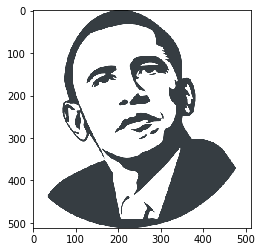

In [139]:
import requests
from io import BytesIO
from scipy.ndimage import imread

url = 'https://upload.wikimedia.org/wikipedia/commons/b/b8/Barack_Obama_icône.png'

picture = requests.get(url)
if picture.ok:
    image = plt.imread(BytesIO(picture.content))
    plt.imshow(image)

Ok back to our original data from the API. So it turns out that there are several 'places' associated with the name 'Empire State Building'. In particular we now have point locations (latitude and longitude) and even a full display address that we could use to add value to our data. Which one you pick is up to you but note that LocationIQ also provides an 'importance' attribute that you could use to filter your results.

For now, let's extract the latitude and longitude and put this on a map, all in Python. We're going to use `cartopy` to generate our maps and handle the projections for us. For more on `cartopy` check out [its documentation here](https://scitools.org.uk/cartopy/docs/latest/index.html). 

The first time you run this you might get a warning that cartopy is downloading the Natural Earth coastline data. You can read more about the Natural Earth datasets here: https://www.naturalearthdata.com. This is a 

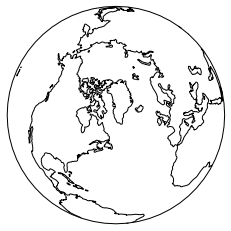

In [44]:
from cartopy import crs
import matplotlib.pyplot as plt
%matplotlib inline

ax = plt.axes(projection=crs.Orthographic(
    central_latitude=65,
    central_longitude=-50
    
))
ax.coastlines()

You can have other basemaps or projections if you want as well

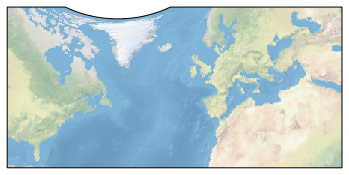

In [119]:
ax = plt.axes(projection=crs.AlbersEqualArea(
    central_latitude=65,
    central_longitude=-50
    
))
ax.stock_img()
ax.set_extent((-90, 40, 20, 60))

If you want a different projection, try one of the others from the `cartopy` project list here: https://scitools.org.uk/cartopy/docs/v0.9/crs/projections.html

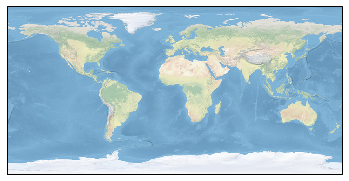

In [99]:
ax = plt.axes(projection=crs.PlateCarree())
ax.stock_img()

So now we can parse the latitude and longitude points from the API and plot these

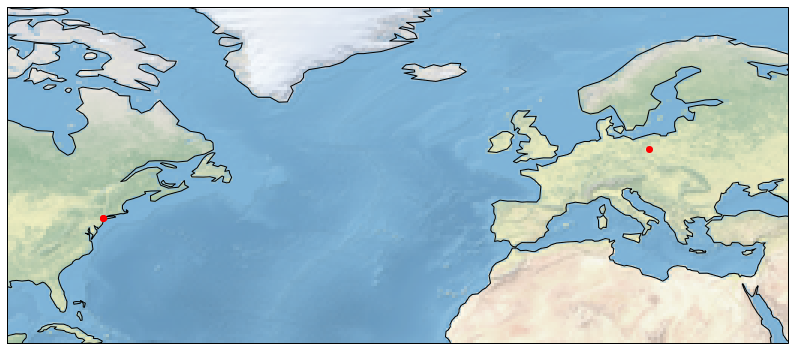

In [146]:
import numpy

# Extract our points for each hit
points = numpy.array([
    (float(hit['lon']), float(hit['lat'])) for hit in response.json()
]).transpose()

# Generate our basemap & points
proj = crs.PlateCarree()
ax = plt.axes(projection=proj)
ax.set_extent((-90, 40, 20, 60))  # sets bounds as (min_lon, max_lon, min_lat, max_lat)
plt.plot(points[0], points[1], 'ro')
ax.stock_img()
ax.coastlines()

# Resize the image to make it a bit bigger
plt.gcf().set_size_inches(14, 8)

Congratulations, you've made a Python version of Google Maps (without the UI polish of the original)!

If you want to make a pointy-clicky-scrolly version then take a look at folium https://github.com/python-visualization/folium, although if you're doing this seriously then you probably want to switch to a better front end language than Python (i.e. JavaScript). Typically geospatial processing 

### Exercise

Write a function `get_position` that geocodes a given location. Start with the following

```python
def get_position(location_string):
    """ Get the latitude and longitude of the given location
    
        Returns the location with the highest likelihood from the LocationIQ API
     
        Parameters:
            location_string - The location to geocode, for example
                'Eiffel Tower' or 'Empire State Building'
        
        Returns:
            the location as a tuple: (longitude, latitude)
    """
    # your code here
```

Then make a list of addresses in Pandas (as a Pandas Series) and apply your function to generate longitude & latitude columns in the data